In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
from scipy.signal import find_peaks, savgol_filter
from scipy.special import wofz
import scipy.stats
from scipy.optimize import curve_fit
from boxsers.preprocessing import savgol_smoothing, als_baseline_cor, spectral_normalization, spectral_cut
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.decomposition import PCA, FactorAnalysis

In [3]:
import sys
sys.path.append('../tools')
from analysis import *

In [4]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [5]:
def combined_gaussian(x, *params):
    N = len(params) // 3
    result = np.zeros_like(x)
    for i in range(N):
        mu, sigma, amplitude = params[i*3:(i+1)*3]
        result += amplitude * np.exp(-0.5 * ((x - mu) / sigma)**2)
    return result

def gaussian(x, mu, sigma, amplitude):
    return amplitude * np.exp(-0.5 * ((x - mu) / sigma)**2)


def combined_pseudo_voigt(x, *params):
    N = len(params) // 4
    result = np.zeros_like(x)
    for i in range(N):
        mu, sigma, amplitude, eta = params[i*4:(i+1)*4]
        gaussian_term = amplitude * np.exp(-0.5 * ((x - mu) / sigma)**2)
        lorentzian_term = (1.0 - eta) * (sigma / ((x - mu)**2 + sigma**2))
        result += eta * gaussian_term + lorentzian_term
    return result

def pseudo_voigt(x, mu, sigma, amplitude, eta):
    gaussian_term = amplitude * np.exp(-0.5 * ((x - mu) / sigma)**2)
    lorentzian_term = (1.0 - eta) * (sigma / ((x - mu)**2 + sigma**2))
    result = eta * gaussian_term + lorentzian_term
    return result

In [6]:
pd.options.display.float_format = '{:.5f}'.format

In [7]:
def corr_plot(X, y):
    r, p_val = pearsonr(X, y)
    
    model = LinearRegression()
    model.fit(X.reshape(-1, 1), y)
    
    x_range = np.linspace(min(X), max(X))
    predicted = model.predict(x_range.reshape(-1, 1))
    
    if p_val < 0.00001:
        text = f"$R = {r:.3f}$\n$p < 0.00001$\n$y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}$"
    else:
        text = f"$R = {r:.3f}$\n$p = {p_val:.5f}$\n$y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}$"
        
    plt.scatter(X, y, facecolor='w', edgecolor='k')
    plt.plot(x_range, predicted, color='r', linewidth=1.5)
    plt.xlabel("$y_1$")
    plt.ylabel("$y_2$")

    x_offset = (max(X) - min(X)) * 0.02
    y_offset = (max(y) - min(y)) * 0.02
    text_x = min(X)
    text_y = max(y)

    print(text)
    
    plt.text(text_x, text_y, text, verticalalignment='top')

In [8]:
df = pd.read_csv("../data/dataset.csv")
max_abs = df.drop(columns=['HbA1c', 'years']).apply(lambda row: True if row.max() > 0.30 else False, axis=1)
df = df[max_abs]

areas = pd.read_csv("../data/areas_voigt_n.csv")
areas['HbA1c'] = df['HbA1c'].to_numpy()
areas['age'] = df['years'].to_numpy()

fwhm = pd.read_csv("../data/fwhm_voigt_n.csv")
fwhm['HbA1c'] = df['HbA1c'].to_numpy()
fwhm['age'] = df['years'].to_numpy()

# sigma = pd.read_csv("../data/sigma_voigt_b.csv")
# sigma['HbA1c'] = df['HbA1c'].to_numpy()
# sigma['age'] = df['years'].to_numpy()

amplitude = pd.read_csv("../data/amplitude_voigt_n.csv")
amplitude['HbA1c'] = df['HbA1c'].to_numpy()
amplitude['age'] = df['years'].to_numpy()

delta = pd.read_csv("../data/delta_voigt_n.csv")
delta['HbA1c'] = df['HbA1c'].to_numpy()
delta['age'] = df['years'].to_numpy()

In [9]:
areas.corr()['HbA1c'].abs().sort_values(ascending=False).head(20)

HbA1c       1.00000
1005-1014   0.33468
1446-1458   0.32611
1566-1570   0.29260
1100-1110   0.28120
1022-1035   0.26772
1600-1603   0.25683
1410-1428   0.25358
1681-1685   0.22845
1576-1580   0.22084
1616-1619   0.21287
1551-1554   0.20486
1665-1670   0.20332
1581-1584   0.19613
1036-1048   0.18758
1360-1370   0.18103
1643-1646   0.17070
1185-1215   0.17004
1225-1245   0.16469
1465-1475   0.15965
Name: HbA1c, dtype: float64

In [10]:
fwhm.corr()['HbA1c'].abs().sort_values(ascending=False).head(20)

HbA1c       1.00000
1070-1090   0.37116
1446-1458   0.33603
1665-1670   0.33097
1681-1685   0.30293
1627-1630   0.27029
1655-1657   0.25959
1650-1654   0.25822
1672-1675   0.23602
1410-1428   0.21961
1604-1606   0.18488
1022-1035   0.18297
1225-1245   0.18218
1585-1587   0.18113
1496-1500   0.18091
1185-1215   0.18025
1631-1634   0.17996
1566-1570   0.17660
1542-1545   0.17079
1360-1370   0.16673
Name: HbA1c, dtype: float64

In [36]:
#delta.corr()['HbA1c'].abs().sort_values(ascending=False).head(20)

In [35]:
#amplitude.corr()['HbA1c'].abs().sort_values(ascending=False).head(20)

In [14]:
X_areas = areas.drop(columns=['HbA1c', 'age'])
hba1c = areas['HbA1c']

sel_columns = []
hba1c_columns = []

for i in range(len(X_areas.columns)):
    area = X_areas.iloc[:, i]
    r, p_val = pearsonr(hba1c, area)

    if p_val < 0.05 / len(X_areas.columns):
        hba1c_columns.append(X_areas.columns[i])
        sel_columns.append((X_areas.columns[i], r, p_val))

print(len(sel_columns))
sorted(sel_columns, key=lambda x: abs(x[1]), reverse=True)

13


[('1005-1014', 0.3346763940508803, 3.98967948810766e-09),
 ('1446-1458', 0.3261055415580089, 1.0344245552006819e-08),
 ('1566-1570', -0.29260094547147397, 3.2573863410512205e-07),
 ('1100-1110', 0.28120003479179356, 9.570571563122444e-07),
 ('1022-1035', 0.2677243012327589, 3.2204593706676116e-06),
 ('1600-1603', -0.25682788744755203, 8.197690580088283e-06),
 ('1410-1428', -0.25358402928425333, 1.0740821533580761e-05),
 ('1681-1685', 0.22844629022582832, 7.725976397063506e-05),
 ('1576-1580', -0.2208373290749991, 0.00013471244020569852),
 ('1616-1619', -0.21287421637016765, 0.00023625908841968553),
 ('1551-1554', -0.20485657466001014, 0.000407529248278202),
 ('1665-1670', 0.20332354220064308, 0.0004512592733930444),
 ('1581-1584', -0.1961313601364731, 0.0007208397640087345)]

In [15]:
X_delta = delta.drop(columns=['HbA1c', 'age'])
#hba1c = areas['HbA1c']

sel_columns = []
hba1c_columns = []

for i in range(len(X_delta.columns)):
    deltas = X_delta.iloc[:, i]
    r, p_val = pearsonr(hba1c, deltas)

    if p_val < 0.05 / len(X_delta.columns):
        hba1c_columns.append(X_delta.columns[i])
        sel_columns.append((X_delta.columns[i], r, p_val))

print(len(sel_columns))
sorted(sel_columns, key=lambda x: abs(x[1]), reverse=True)

15


[('1646-1649', 0.3290307865180988, 7.497489649553434e-09),
 ('1581-1584', 0.2978271116559734, 1.9559657857798427e-07),
 ('1659-1663', -0.29300362689464454, 3.132985136693822e-07),
 ('1100-1110', 0.27987010821565633, 1.0819350086678553e-06),
 ('1410-1428', 0.26959416057380875, 2.7319385062408498e-06),
 ('1005-1014', 0.26309131061426283, 4.815527571318386e-06),
 ('1631-1634', -0.25752972518210127, 7.728505742534241e-06),
 ('1622-1626', 0.25620173612188313, 8.639029030539474e-06),
 ('1650-1654', 0.2550438370290687, 9.51532721997895e-06),
 ('1275-1290', -0.24670364904136585, 1.8825995462557034e-05),
 ('1185-1215', 0.2459948902547359, 1.9928146902397595e-05),
 ('1604-1606', 0.2356710061252619, 4.4777861565490624e-05),
 ('1672-1675', -0.23015123408477098, 6.803365543364539e-05),
 ('1635-1638', -0.2204258176592546, 0.00013875008806625165),
 ('1588-1592', -0.2180678642901429, 0.00016415930477541396)]

In [16]:
X_fwhm = fwhm.drop(columns=['HbA1c', 'age'])
#hba1c = areas['HbA1c']

sel_columns = []
hba1c_columns = []

for i in range(len(X_fwhm.columns)):
    width = X_fwhm.iloc[:, i]
    r, p_val = pearsonr(hba1c, width)

    if p_val < 0.05 / len(X_fwhm.columns):
        hba1c_columns.append(X_fwhm.columns[i])
        sel_columns.append((X_fwhm.columns[i], r, p_val))

print(len(sel_columns))
sorted(sel_columns, key=lambda x: abs(x[1]), reverse=True)

9


[('1070-1090', -0.37116107626989214, 4.92249006370981e-11),
 ('1446-1458', 0.33602884198504435, 3.423548693032375e-09),
 ('1665-1670', 0.330966975711956, 6.0475544581446975e-09),
 ('1681-1685', 0.30293280731178734, 1.1767406046131284e-07),
 ('1627-1630', 0.27029139773968697, 2.568575945425956e-06),
 ('1655-1657', 0.25958832980704843, 6.495187521946898e-06),
 ('1650-1654', 0.25821679360937994, 7.294014121481433e-06),
 ('1672-1675', 0.23602026574368132, 4.359348139281234e-05),
 ('1410-1428', -0.21961309251191513, 0.00014705967455615074)]

In [17]:
def get_secondary_structure(areas_df):
    intermol_beta_sheet = areas_df['1611-1614'] + areas_df['1616-1619'] + areas_df['1622-1626']
    beta_sheet = areas_df['1627-1630'] + areas_df['1631-1634'] + areas_df['1635-1638'] + areas_df['1639-1641']
    random_coil = areas_df['1643-1646'] + areas_df['1646-1649']
    alpha_helix = areas_df['1650-1654'] + areas_df['1655-1657']
    beta_turn = (areas_df['1659-1663'] + areas_df['1665-1670'] + 
                 areas_df['1672-1675'] + areas_df['1678-1680'] + 
                 areas_df['1681-1685'] + areas_df['1686-1689'] +
                 areas_df['1693-1696'] + areas_df['1698-1700']
                )
    result = {
        "intermol beta sheet": intermol_beta_sheet,
        "beta sheet": beta_sheet,
        "random coil": random_coil,
        "alpha helix": alpha_helix,
        "beta turn": beta_turn
    }
    
    return result

$R = -0.160$
$p = 0.00612$
$y = -0.96060x + 22.54517$


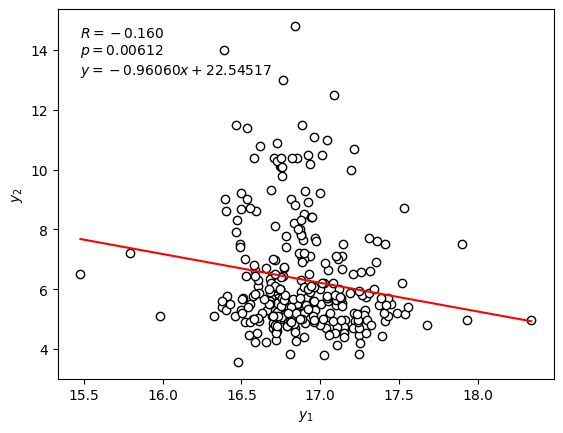

In [18]:
sec_structure = get_secondary_structure(areas)
all_beta = sec_structure['beta sheet'] + sec_structure['intermol beta sheet'] + sec_structure['beta turn']
corr_plot(all_beta.to_numpy(), hba1c)

$R = 0.335$
$p < 0.00001$
$y = 10.30428x + 5.21100$


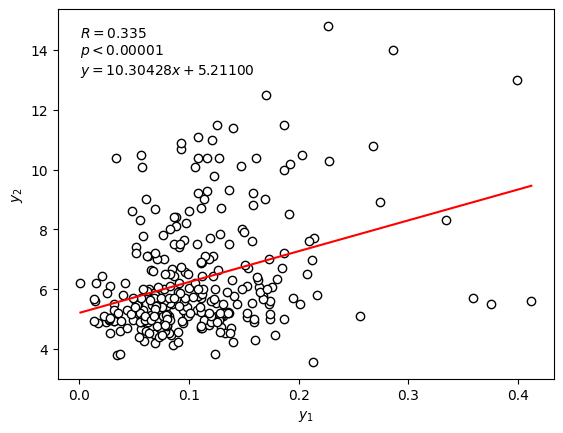

In [19]:
corr_plot(areas['1005-1014'].to_numpy(), hba1c)

$R = 0.091$
$p = 0.11891$
$y = 1.04798x + -0.84793$


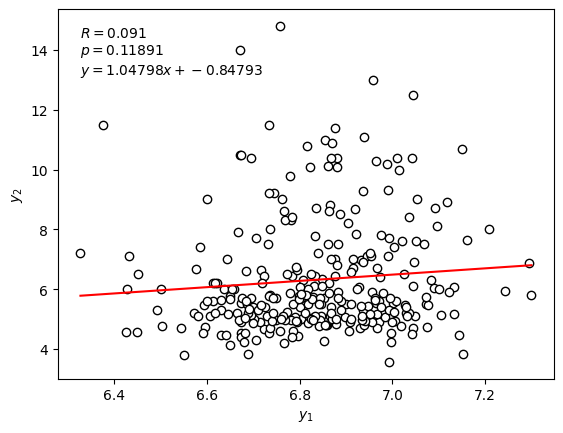

In [20]:
corr_plot(sec_structure['beta turn'].to_numpy(), hba1c)

In [21]:
diabetes = df['HbA1c'].apply(lambda hba1c: True if hba1c >= 6.5 else False).to_numpy()
secondary_structure = pd.DataFrame(sec_structure)
secondary_structure['HbA1c'] = hba1c

h_df = areas[areas['HbA1c'] < 6.5]
d_df = areas[areas['HbA1c'] >= 6.5]

h_df_delta = delta[delta['HbA1c'] < 6.5]
d_df_delta = delta[delta['HbA1c'] >= 6.5]

h_df_fwhm = fwhm[fwhm['HbA1c'] < 6.5]
d_df_fwhm = fwhm[fwhm['HbA1c'] >= 6.5]

h_df_s = secondary_structure[secondary_structure['HbA1c'] < 6.5]
d_df_s = secondary_structure[secondary_structure['HbA1c'] >= 6.5]
d_df_s

,intermol beta sheet,beta sheet,random coil,alpha helix,beta turn,HbA1c
0,4.51244,5.24929,2.73406,2.55013,6.73040,7.50000
2,4.30452,5.65262,2.70273,2.31570,6.92046,7.86000
13,4.40990,5.45911,2.81385,2.20064,6.71605,6.64000
14,4.73833,5.21042,2.84661,2.38591,6.83389,7.79000
17,4.49582,5.28757,2.72555,2.30966,6.93168,6.99000
...,...,...,...,...,...,...
289,4.58828,5.46431,2.84237,2.44006,6.69575,10.40000
290,4.50340,5.12992,2.77925,2.21600,6.76067,9.00000
291,4.50090,5.93755,3.46821,1.82853,6.77177,6.50000
292,4.48482,5.57512,2.82111,2.40036,6.83895,7.20000


In [22]:
h_df_s['intermol beta sheet'].mean()

4.599301552677451

In [23]:
d_df_s['intermol beta sheet'].mean()

4.486497549843421

In [24]:
from scipy.stats import ttest_ind

diabetes_features_area = []
diabetes_features_fwhm = []
diabetes_features_delta = []

for column in h_df.columns[:-2]:
    healthy_data = h_df[column]
    diabetes_data = d_df[column]

    t_statistic, p_value = ttest_ind(healthy_data, diabetes_data)

    if p_value < 0.05:
        diabetes_features_area.append(column)
        print(f"T-test for '{column}': (area)")
        print(f"T-statistic: {t_statistic}")
        print(f"P-value: {p_value}")
        print("")

for column in h_df_delta.columns[:-2]:
    healthy_data = h_df_delta[column]
    diabetes_data = d_df_delta[column]

    t_statistic, p_value = ttest_ind(healthy_data, diabetes_data)

    if p_value < 0.05 / len(h_df_delta.columns):
        diabetes_features_delta.append(column)
        print(f"T-test for '{column}': (delta)")
        print(f"T-statistic: {t_statistic}")
        print(f"P-value: {p_value}")
        print("")

for column in h_df_fwhm.columns[:-2]:
    healthy_data = h_df_fwhm[column]
    diabetes_data = d_df_fwhm[column]

    t_statistic, p_value = ttest_ind(healthy_data, diabetes_data)

    if p_value < 0.05 / len(h_df_fwhm.columns):
        diabetes_features_fwhm.append(column)
        print(f"T-test for '{column}': (fwhm)")
        print(f"T-statistic: {t_statistic}")
        print(f"P-value: {p_value}")
        print("")

for column in h_df_s.columns[:-1]:
    healthy_data = h_df_s[column]
    diabetes_data = d_df_s[column]

    t_statistic, p_value = ttest_ind(healthy_data, diabetes_data)

    if p_value < 0.05 / len(h_df_s.columns):
        print(f"T-test for '{column}':")
        print(f"T-statistic: {t_statistic}")
        print(f"P-value: {p_value}")
        print("")

T-test for '1005-1014': (area)
T-statistic: -4.195401995829622
P-value: 3.617515340980933e-05

T-test for '1022-1035': (area)
T-statistic: -3.2206788616604136
P-value: 0.0014232699087902898

T-test for '1036-1048': (area)
T-statistic: -2.8919120032131254
P-value: 0.004116822856793417

T-test for '1050-1060': (area)
T-statistic: -2.486437761380166
P-value: 0.013461812405426071

T-test for '1100-1110': (area)
T-statistic: -4.362397511152325
P-value: 1.786176906230109e-05

T-test for '1185-1215': (area)
T-statistic: 3.153384666245011
P-value: 0.0017819612930922149

T-test for '1225-1245': (area)
T-statistic: -3.0174664822535626
P-value: 0.0027735869233987695

T-test for '1275-1290': (area)
T-statistic: 2.3335676370462304
P-value: 0.020297010515649274

T-test for '1335-1345': (area)
T-statistic: 2.2457182575872157
P-value: 0.025469894554355357

T-test for '1360-1370': (area)
T-statistic: -3.378211098016109
P-value: 0.0008286896745697273

T-test for '1410-1428': (area)
T-statistic: 4.195221

$R = 0.157$
$p = 0.00698$
$y = 2.11732x + 1.49901$


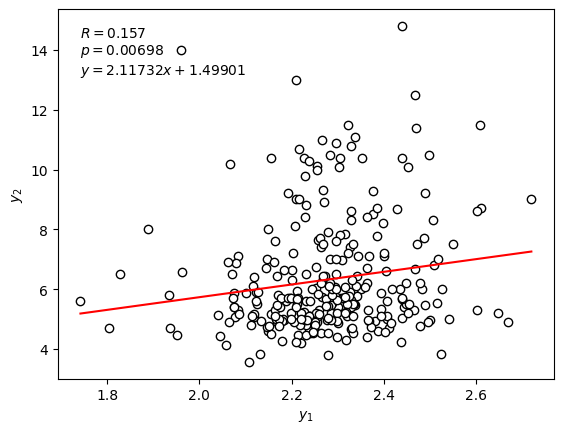

In [25]:
corr_plot(sec_structure['alpha helix'].to_numpy(), df['HbA1c'])

In [26]:
X_areas[diabetes_features_area]

,1005-1014,1022-1035,1036-1048,1050-1060,1100-1110,1185-1215,1225-1245,1275-1290,1335-1345,1360-1370,...,1576-1580,1581-1584,1600-1603,1616-1619,1631-1634,1635-1638,1643-1646,1665-1670,1681-1685,1686-1689
0,0.10762,0.18764,0.67191,1.39141,1.39956,2.25748,3.84446,1.30845,3.94081,1.42422,...,0.80201,0.85964,1.42597,1.52048,1.04670,1.51291,1.45640,1.80116,0.40956,0.39891
1,0.08324,0.39751,0.61071,0.29244,0.90815,3.51084,2.52420,1.08416,4.56241,1.16461,...,0.78800,0.93294,1.68095,1.72255,1.24230,1.32363,1.51681,1.62648,0.41664,0.77261
2,0.12824,0.20861,0.60173,1.36538,1.20222,3.00950,3.41327,1.26999,4.02082,1.39153,...,0.71651,0.69351,1.62220,1.54622,1.37094,1.32449,1.36630,1.78974,0.40882,0.56075
3,0.37522,0.32086,0.93362,0.88411,0.98020,3.00645,2.43927,2.73501,3.81491,1.41575,...,0.81476,0.83615,1.65847,1.44821,1.26856,1.46280,1.49320,1.88529,0.41514,0.47493
4,0.07600,0.43701,0.94227,0.83001,0.89531,2.88088,3.88957,2.66210,4.41070,1.72903,...,0.67113,0.88064,1.65397,1.36387,1.28953,1.33921,2.19695,1.71992,0.31486,0.70258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,0.11587,0.45474,0.00021,1.30643,1.21635,2.87745,3.12664,1.36217,3.70944,1.61841,...,0.78561,0.76032,1.30606,1.38700,1.33141,1.40086,1.45583,1.69350,0.47718,0.53912
290,0.11340,0.18700,0.93107,0.79455,1.30365,2.89621,3.21387,1.83961,4.03487,1.50612,...,0.78738,0.79324,1.53054,1.72217,1.16206,1.33097,1.41005,1.49402,0.35885,0.52504
291,0.07771,0.17155,0.53654,1.10193,1.27714,2.42219,2.96373,3.33048,2.03941,3.00418,...,0.88114,0.87674,1.32655,1.41182,1.33584,1.52979,0.66587,1.80493,0.48600,0.49169
292,0.06858,0.28552,0.71257,1.03535,1.27688,2.93175,3.00630,2.96798,3.41814,1.89775,...,0.80345,0.79257,1.46678,1.31179,1.32851,1.47157,1.45628,1.83649,0.34805,0.54920


In [27]:
db = hba1c.apply(lambda x: 1 if x >= 6.5 else 0).to_numpy()

In [28]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score

In [29]:
X_combined = pd.concat([X_areas[diabetes_features_area], X_fwhm[diabetes_features_fwhm], X_delta[diabetes_features_delta]], axis=1)

In [30]:
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform', subsample=None, random_state=24)
categories = discretizer.fit_transform(hba1c.to_numpy().reshape(-1, 1))

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_fwhm[diabetes_features_fwhm], db, test_size=0.3, stratify=db, random_state=44)

model = RandomForestClassifier(n_estimators=200, n_jobs=10, random_state=44)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, n_jobs=10, random_state=44)

In [32]:
predicted = model.predict(X_test)
accuracy_score(y_test, predicted)

0.8651685393258427

In [33]:
fa = FactorAnalysis(n_components=10)
fa.fit_transform(X_areas)
fa.components_[0]

array([-2.20241786e-02,  5.44872699e-03, -6.24197109e-02,  6.28471893e-02,
       -7.83636702e-02,  2.00837824e-02,  1.61626144e-02, -3.86745310e-01,
        4.22252505e-01, -9.03437889e-02,  1.42900187e-01, -1.65796545e-01,
        7.75394058e-02,  9.91157525e-02, -2.47352361e-01,  1.48314637e-01,
       -1.11205851e-01,  7.26309404e-02, -2.60910779e-02, -1.96109936e-02,
        5.08667158e-02,  4.91344668e-03,  6.49152539e-03,  4.21855785e-03,
        2.04503211e-02,  3.27602136e-02,  1.87294703e-02, -1.38542873e-02,
       -9.44740909e-02, -4.31176894e-02,  4.42590831e-02, -2.15715406e-02,
        8.98640317e-03,  3.71731671e-03,  3.08776888e-02,  2.97882257e-02,
        5.29388321e-02, -5.36218968e-02,  3.50730808e-02, -1.62237244e-02,
       -1.75349112e-02,  3.64504195e-04,  3.88207941e-02, -6.95605156e-02,
        1.91599209e-02,  1.26160897e-02,  2.94777567e-02, -1.77494489e-02,
       -1.99446067e-02,  1.67465606e-02,  4.46197026e-02, -2.47104310e-03,
       -8.72397041e-03, -